In [27]:
import polars as pl
import plotnine as p9
from p9customtheme import custom_theme, custom_discrete
from cstbioinfo.embedding import EmbedderModel
from cstbioinfo.embedding.tl import umap
from functools import partial

# Define a partial function for UMAP with specific parameters
# So that all models are using the same parameters
umap_partial = partial(umap, n_neighbors=50, min_dist=0.5)

In [ ]:
# Download a example dataset from OAS
url = "https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Alsoiussi_2020/csv/SRR11528761_paired.csv.gz"
n = 300
df = pl.read_csv(url, has_header=True, skip_rows=1, separator=",", n_rows=n)


In [24]:
# Initialize the embedder model
model = EmbedderModel.PIGGEN
embedder = EmbedderModel.get_embedder(model)

print(f"Downloaded {df.shape[0]} example sequences from OAS.")

Downloaded 300 example sequences from OAS.


In [25]:
# Embed the sequences, this can take a while depending on the model and your hardware
embeddings = embedder.embed(
    df.get_column("sequence_alignment_aa_heavy").to_list(), batch_size=1
)
print(f"Embedded {len(embeddings)} sequences with shape {embeddings[0].shape}.")

Embedding sequences: 100%|██████████| 300/300 [00:35<00:00,  8.37it/s]

Embedded 300 sequences with shape torch.Size([768]).


In [28]:
# quickly make a umap from the embeddings, this can then be combined with the original dataframe
df_umap = umap_partial(embeddings)
df_umap = df_umap.rename(lambda column_name: f"{model.name}_{column_name}")
print(f"Reduced the embeddings to {df_umap.shape} dimensions with UMAP.")

Reduced the embeddings to (300, 2) dimensions with UMAP.


In [29]:
# Add the UMAP embeddings to the original dataframe
df_embedding = pl.concat([df, df_umap], how="horizontal")


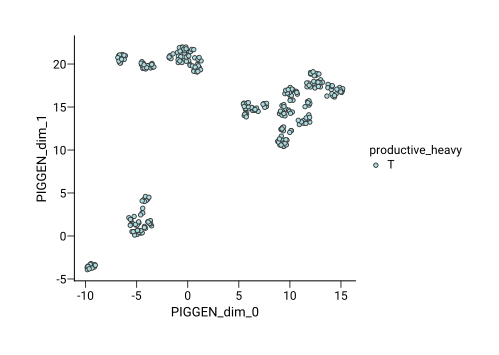

In [30]:
(
    p9.ggplot(
        df_embedding,
        p9.aes(x="PIGGEN_dim_0", y="PIGGEN_dim_1", fill="productive_heavy"),
    )
    + p9.geom_point()
    + custom_discrete()
)

In [31]:
# Now the same embedding can be done with a different model, e.g. ANARCII
model = EmbedderModel.ANARCII
embedder = EmbedderModel.get_embedder(model)
embeddings = embedder.embed(df.get_column("sequence_alignment_aa_heavy").to_list())
print(f"Embedded {len(embeddings)} sequences with shape {embeddings[0].shape}.")
df_umap = umap_partial(embeddings)
df_umap = df_umap.rename(lambda column_name: f"{model.name}_{column_name}")
print(f"Reduced the embeddings to {df_umap.shape} dimensions with UMAP.")
df_embedding = pl.concat([df_embedding, df_umap], how="horizontal")

Embedding sequences: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]



Embedded 300 sequences with shape torch.Size([128]).
Reduced the embeddings to (300, 2) dimensions with UMAP.
Reduced the embeddings to (300, 2) dimensions with UMAP.


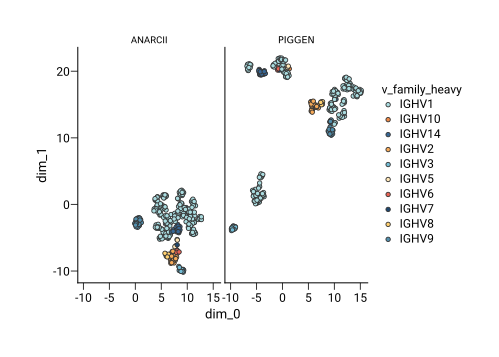

In [32]:
df_subset = df_embedding.with_columns(
    pl.col("v_call_heavy").str.split("-").list.first().alias("v_family_heavy")
).select(
    "v_family_heavy",
    "ANARCII_dim_0",
    "ANARCII_dim_1",
    "PIGGEN_dim_0",
    "PIGGEN_dim_1",
)
anarci_df = (
    df_subset.select(["v_family_heavy", "ANARCII_dim_0", "ANARCII_dim_1"])
    .rename({"ANARCII_dim_0": "dim_0", "ANARCII_dim_1": "dim_1"})
    .with_columns(pl.lit("ANARCII").alias("model"))
)
piggen_df = (
    df_subset.select(["v_family_heavy", "PIGGEN_dim_0", "PIGGEN_dim_1"])
    .rename({"PIGGEN_dim_0": "dim_0", "PIGGEN_dim_1": "dim_1"})
    .with_columns(pl.lit("PIGGEN").alias("model"))
)
embeddings = pl.concat([anarci_df, piggen_df], how="vertical")
(
    p9.ggplot(embeddings, p9.aes(x="dim_0", y="dim_1", fill="v_family_heavy"))
    + p9.geom_point()
    + p9.facet_wrap("model")
    + custom_discrete()
    + custom_theme()
)